In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from hyperion.model import ModelOutput
import astropy.constants as const

AU = const.au.cgs.value
pc = const.pc.cgs.value
MS = const.M_sun.cgs.value
mh = const.m_p.cgs.value + const.m_e.cgs.value
dstar = 178. * pc

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
filename = '/Users/yaolun/bhr71/hyperion/model12.rtout'
m = ModelOutput(filename)

q = m.get_quantities()
r_wall, t_wall, p_wall = q.r_wall, q.t_wall, q.p_wall
rc     = 0.5*( r_wall[0:len(r_wall)-1] + r_wall[1:len(r_wall)] )
thetac = 0.5*( t_wall[0:len(t_wall)-1] + t_wall[1:len(t_wall)] )
phic   = 0.5*( p_wall[0:len(p_wall)-1] + p_wall[1:len(p_wall)])

rho = q['density'][0].array.T

In [3]:
def cell_size(gridi, q):
    # grid index in cell coordinates
    ir, itheta, iphi = gridi
    
    ri, thetai, phii = q.r_wall, q.t_wall, q.p_wall
    
    vol = (1/3.)*(ri[ir+1]**3 - ri[ir]**3) * (phii[iphi+1]-phii[iphi]) * -(np.cos(thetai[itheta+1])-np.cos(thetai[itheta]))
    
    return vol

## Diffraction limited beam

### 1.2 $\mu$m - 0.124 arcsec

### 1.6 $\mu$m - 0.165 arcsec

In [4]:
# beam size
beam = 0.124
def enclose_mass(beam, los=90.):
    beam_rad = beam/2 * dstar/pc * AU # beam radius in cm
    rad_limit = beam*dstar/pc*AU / ((2*(1-np.cos(np.pi/len(thetac))))**0.5)
#     beam/2*dstar/pc*AU/np.sin(2*np.pi/len(thetac))
    mass_column = 0
    total_mass = 0
    
    itheta = np.argsort(abs(thetac-np.radians(los)))[0]
    print itheta
    # Projected distance on the plane perpendicular to LOS
    # first need to do coordinates rotation
    rot_angle = np.radians(90.-los)
    
    dist = np.empty_like(rho) 
    for ir in range(len(rc)):
        # avoid empty cell
        if rc[ir] <= 0.1*AU:
            continue
        for it in range(len(thetac)):
            for ip in range(len(phic)):
                dist[ir,it,ip] = (( rc[ir]*np.sin(thetac[it]+rot_angle)*np.sin(phic[ip]) )**2 +\
                                  ( rc[ir]*np.cos(thetac[it]+rot_angle) )**2)**0.5

                if dist[ir,it,ip] <= beam_rad:
                    # If the projected spacing between adjacent cell in polar angle is smaller than the beam radius,
                    # the cell is considered "entirely" within the beam.  Its density is calculated and added to column
                    # density.  If the projected spacing between adjacent cell in polar angle is greater than the beam
                    # radius, the cel is considered "more extended" than the beam.  The added density is calculated by
                    # the density of the cell times the segment of column that falls in the cell.
                    if rc[ir] <= rad_limit:
                        mass_column += rho[ir,it,ip] * cell_size((ir,it,ip),q)
                
                total_mass += rho[ir,it,ip]*cell_size((ir,it,ip),q)
        if rc[ir] > rad_limit:
            mass_column += (r_wall[ir+1]-r_wall[ir]) * np.pi*beam_rad**2 * rho[ir,itheta,0]
    area = np.pi*beam_rad**2        
    
    print total_mass/MS
    
    return mass_column, area

### Another version works in Cartesian (cannot do different LOS, maybe it can...)

In [56]:
def enclose_mass_cart(beam, grid_ref, los=90.):
    beam_rad = beam/2 * dstar/pc * AU # beam radius in cm
    mass_column = 0
    total_mass = 0
    
    # Projected distance on the plane perpendicular to LOS
    # first need to do coordinates rotation
    rot_angle = np.radians(90.-los)
    
    dist = np.empty_like(rho)
    # reference point on yz-plane
    y_ref, z_ref = grid_ref
    y_ref = y_ref * dstar/pc*AU
    z_ref = z_ref * dstar/pc*AU
                
    for ir in range(len(rc)):
        # avoid empty cell
        if rc[ir] <= 0.1*AU:
            continue
        for it in range(len(thetac)):
            for ip in range(len(phic)):
                # convert the spherical coordinates to cartiesian coordinates
                x = rc[ir]*np.sin(thetac[it]+rot_angle)*np.cos(phic[ip])
                y = rc[ir]*np.sin(thetac[it]+rot_angle)*np.sin(phic[ip])
                z = rc[ir]*np.cos(thetac[it]+rot_angle)
                
                dist[ir,it,ip] = ((y-y_ref)**2 + (z-z_ref)**2)**0.5

                if dist[ir,it,ip] <= beam_rad:
                    mass_column += rho[ir,it,ip] * cell_size((ir,it,ip),q)
                
                total_mass += rho[ir,it,ip] * cell_size((ir,it,ip),q)
                
    area = np.pi*beam_rad**2
    
#     print total_mass/MS
    
    return mass_column, area

### Make sure I understand the geometry

(1e-22, 1e-12)

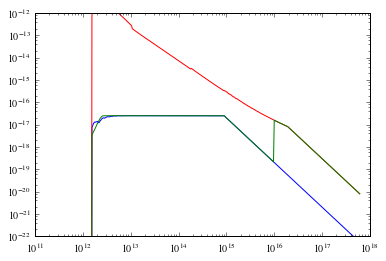

In [29]:
#collapse rho(r, theta, phi) to rho(r, theta)
rho_2d = np.sum(rho, axis=2)

plt.plot(rc, rho_2d[:,0], color='b')
plt.plot(rc, rho_2d[:,199], color='r')
plt.plot(rc, rho_2d[:,99], color='g')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-22, 1e-12])

In [57]:
# test
beam = 0.1
los =90.
mass, area = enclose_mass_cart(beam, (0,0), los=los)

In [59]:
print mass/MS, mass*100/mh/area*8.645e-27

9.68457004115e-07 0.0178684566436


In [48]:
x = np.arange(0, 2.1, 0.1)
# Aj = np.empty_like(x)
# Ah = np.empty_like(x)
tau_870 = np.empty_like(x)
beam = 0.1
los=90.

# foo = open('/Users/yaolun/Google Drive/proposal/ALMA/column_density_los'+str(los)+'.txt','w')
# foo.write('%s \t %s \n' % ('offset[arcsec]', 'N_H[cm-3]'))

for ix in range(len(x)):
    mass, area = enclose_mass_cart(beam, (0,-x[ix]), los=los)
    Nh = mass*100./mh/area
#     Aj[ix] = 1.086 * 1.994e-22 * Nh
#     Ah[ix] = 1.086 * 1.203e-22 * Nh
    tau_870[ix] = 8.645e-27 * Nh

#     foo.write('%f \t %f \n' % (x[ix], Nh))

foo.close()

0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621
0.21785407621


In [259]:
from scipy.interpolate import interp1d
f_j = interp1d(Aj, x)
f_h = interp1d(Ah, x)

print f_j(5)*150, f_h(5)*150

175.420667583 166.659553139


In [268]:
from astropy.io import ascii
data = ascii.read('/Users/yaolun/Dropbox/HST_cycle24/column_density.txt')
for ix in range(len(x)):
    Nh = data['N_H[cm-3]'][ix]
    Aj[ix] = 1.086 * 1.994e-22 * Nh
    Ah[ix] = 1.086 * 1.203e-22 * Nh

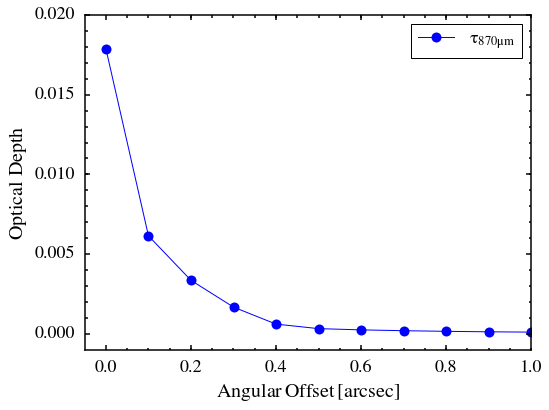

In [63]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# ext_j, = ax.plot(x, Aj, 'bo-', mec='None', markersize=10)
# ext_h, = ax.plot(x, Ah, 'ro-', mec='None', markersize=10)
# ax.axhline(5, color='k', linestyle='--', linewidth=1.2)
tau, = ax.plot(x, tau_870, 'bo-', mec='None', markersize=10)

# ax.legend([ext_j, ext_h], [r'$\rm{A_{J}}$', r'$\rm{A_{H}}$'], loc='best', fontsize=18, numpoints=1)
ax.legend([tau], [r'$\rm{\tau_{870\mu m}}$'], loc='best', fontsize=18, numpoints=1)
ax.set_xlabel(r'$\rm{Angular\,Offset\,[arcsec]}$', fontsize=20)
ax.set_ylabel(r'$\rm{Optical\,\,Depth}$', fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

ax.set_xlim([-0.05, 1])
ax.set_ylim([-0.001, 0.02])

fig.savefig('/Users/yaolun/Google Drive/proposal/ALMA/cycle4/extinction_estimation.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [234]:
wave = 1.6
# rtout for analysis
rt_reg = ModelOutput('/Users/yaolun/bhr71/hyperion/model12.rtout')
rt_const = ModelOutput('/Users/yaolun/bhr71/hyperion/model13.rtout')
rt_r2 = ModelOutput('/Users/yaolun/bhr71/hyperion/model14.rtout')
rt_incl = ModelOutput('/Users/yaolun/bhr71/hyperion/model15.rtout')

In [235]:
# get image
def get_image(m):
    image = m.get_image(group=0, inclination=0, distance=dstar, units='MJy/sr')

    # Find the closest wavelength
    iwav = np.argmin(np.abs(wave - image.wav))

    # Calculate the image width in arcseconds given the distance used above
    # get the max radius
    rmax = max(m.get_quantities().r_wall)
    w = np.degrees(rmax / image.distance) * 3600.

    # Image in the unit of MJy/sr
    # Change it into erg/s/cm2/Hz/sr
    factor = 1e-23*1e6
    # avoid zero in log
    # flip the image, because the setup of inclination is upside down
    val = image.val[::-1, :, iwav] * factor + 1e-30
    
    return val, w

im_reg, w = get_image(rt_reg)
im_const, w = get_image(rt_const)
im_r2, w = get_image(rt_r2)
im_incl, w = get_image(rt_incl)

In [236]:
# rebin function
def rebin(data, width, method='savgol', norm=False, interp=False):
    """
    If the method is "sigma_clip," the value of width will be treated as sigma.
    """
    # the input width for gaussian kernel is FWHM
    from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
    if method == 'boxcar':
        kernel = Box1DKernel(width, mode='center')
        smooth_data = convolve(data, kernel)
    elif method == 'gaussian':
        kernel = Gaussian1DKernel(width/2.354)
        smooth_data = convolve(data, kernel)
    elif method == 'savgol':
        from scipy.signal import savgol_filter
        if width % 2 == 0:
            width = width+1
        smooth_data = savgol_filter(data, width, 2)
    elif method == 'sigma_clip':
        from astropy.stats import sigma_clip
        smooth_data = sigma_clip(data,sigma=width)
        
        # The interpolation function interpolates the masked value with nearby data
        if interp:
            from scipy.interpolate import interp1d
            x = np.linspace(1, len(data), len(data))
            print len(x[smooth_data.mask]), len(smooth_data.data[smooth_data.mask])
            f = interp1d(x[smooth_data.mask], smooth_data.data[smooth_data.mask])
            interp_data = f(x[np.invert(smooth_data.mask)])
            unsort_data = np.hstack((smooth_data.data[smooth_data.mask], interp_data))
            unsort_x = np.hstack((x[smooth_data.mask], x[np.invert(smooth_data.mask)]))
            sorter = np.argsort(unsort_x)
            smooth_data = unsort_data[sorter]
    if norm == True:
        smooth_data = smooth_data/smooth_data.max()
    
    return smooth_data

(-50, 2)

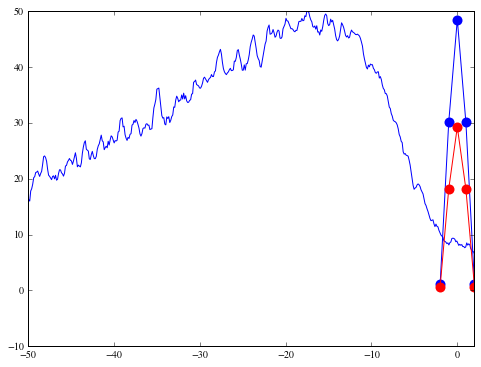

In [243]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

r_im = np.linspace(-w, w, 4000)
rebin_pix = 10
ax.plot(rebin(r_im,rebin_pix), rebin(np.sum(im_reg[:,1949:2049], axis=1), rebin_pix, norm=True) * 50,
        'b-', label=r'$\rm{const.+r^{-2}}$')
ext_j, = ax.plot(x, Aj, 'bo-', mec='None', markersize=10)
ext_h, = ax.plot(x, Ah, 'ro-', mec='None', markersize=10)

ax.set_xlim([-50,2])